In [1]:
# imports
import jax
from flax import nnx
import optax
import jax.numpy as jnp
import dataclasses

from typing import List

In [2]:
jax.devices()

[CudaDevice(id=0)]

# Configuration
This model has more parameters, let's create a special class with configuration parameters

# Configuration
This model has more parameters, let's create a special class with configuration parameters

In [3]:
@dataclasses.dataclass
class Config:
    # Image-related parameters
    image_channels:int = 3
    image_width:int = 256
    image_height:int = 256

    # Architecture related parameters
    num_residual_hiddens:int = 128
    num_residual_input:int = 32
    num_residual_layers_encoder:int = 2

    num_residual_layers_decoder:int = 2

    # quantization-related parameters
    num_quantized_vectors:int = 512
    embedding_dim:int = 64
    commitment_cost:float = 0.25
    
    # Dataset-related parameters
    dataset_name:str = 'bitmind/ffhq-256_training_faces'
    batch_size:int = 32

    # Training related parameters
    learning_rate:float = 3e-4

In [4]:
class ResBlock(nnx.Module):
    """One block of the encoder with a residual connection"""
    def __init__(self, config:Config, rngs: nnx.Rngs):
        super().__init__()
        self.config= config
        self.conv1 = nnx.Conv(in_features=config.num_residual_input, out_features=config.num_residual_hiddens, kernel_size=(3,3), strides=1, padding='SAME', rngs=rngs)
        self.conv2 = nnx.Conv(in_features=config.num_residual_hiddens, out_features=config.num_residual_input, kernel_size=(1,1), strides=1, padding='SAME', rngs=rngs)
    def __call__(self, inputs:jax.Array):
        out = self.conv1(jax.nn.relu(inputs))
        out = self.conv2(jax.nn.relu(out))
        return jax.nn.relu(out+inputs)
    

In [5]:
rngs = nnx.Rngs(0)
config = Config()


In [6]:
class Encoder(nnx.Module):
    """VQVAE encoder"""
    def __init__(self, config: Config, rngs: nnx.Rngs):
        super().__init__()
        self.config = config
        self.res_layers = [ResBlock(config, rngs) for _ in range(self.config.num_residual_layers_encoder)]
        # Three convolutions that reduce resolution by 2 and increase internal 
        self.initial_conv1 = nnx.Conv(in_features=config.image_channels, out_features=config.num_residual_input//2, kernel_size=(4,4), strides=(2, 2), padding='SAME', rngs=rngs)
        self.initial_conv2 = nnx.Conv(in_features=config.num_residual_input//2, out_features=config.num_residual_input, kernel_size=(4,4), strides=(2, 2), padding='SAME', rngs=rngs)
        self.initial_conv3 = nnx.Conv(in_features=config.num_residual_input, out_features=config.num_residual_input, kernel_size= (3,3), strides=(1,1), padding='SAME', rngs=rngs)
        
        
    def __call__(self, input: jax.Array):
        x = jax.nn.relu(self.initial_conv1(input))
        x = jax.nn.relu(self.initial_conv2(x))
        x = jax.nn.relu(self.initial_conv3(x))
        for i, l in enumerate(self.res_layers):
            x = l(x)
        # Flatten output into one vector
        x = x.flatten()
        return x

In [7]:
class Decoder(nnx.Module):
    """ VQVAE decoder """
    def __init__(self, config: Config,  rngs: nnx.Rngs):
        super().__init__()
        self.config = config
        self.res_layers = [ResBlock(config, rngs) for _ in range(self.config.num_residual_layers_decoder)]
        self.conv1 = nnx.Conv(in_features=config.num_residual_input, out_features=config.num_residual_input, kernel_size=(3,3), strides=1, padding="SAME", rngs=rngs)
        self.conv_transpose1 = nnx.ConvTranspose(in_features=config.num_residual_input,out_features=config.num_residual_input//2, kernel_size=(4, 4), strides=2, padding="SAME", rngs=rngs)
        self.conv_transpose2 = nnx.ConvTranspose(in_features=config.num_residual_input//2, kernel_size=(4, 4),out_features=config.image_channels, strides=2, padding="SAME", rngs=rngs)
    def __call__(self, x: jax.Array):
        # Unflatten the input
        x = x.reshape((64, 64, -1))
        x = self.conv1(x)
        for l in self.res_layers:
            x = l(x)
        x = self.conv_transpose1(x)
        x = jax.nn.relu(x)
        x = self.conv_transpose2(x)
        return x

In [8]:
class Quantizer(nnx.Module):
    """ A simple vector quantizer"""
    def __init__(self, config: Config, rngs: nnx.Rngs):
        super().__init__()
        self.config = config
        # Embeddings for quantization
        key = rngs.params()
        embedding_dim = self.config.embedding_dim
        range_val = 1/self.config.num_quantized_vectors
        self.embeddings = nnx.Param(jax.random.uniform(key, (self.config.num_quantized_vectors, embedding_dim), minval=-range_val, maxval=range_val))

    def __call__(self, embedding: jax.Array) -> List[jax.Array]:
        # Reshape into [num_tokens, embeddings_dim]
        emb_notflatten = embedding.reshape((-1, self.config.embedding_dim))

        # Calculate the distances
        distances = jnp.sum(self.embeddings.value**2, axis=1, keepdims=True) + \
                    jnp.sum(emb_notflatten**2, axis=1, keepdims=True).transpose() - \
                    2*jnp.matmul(self.embeddings.value, emb_notflatten.transpose()) # [num_tokens, config.num_quantized_vectors]
        selected_tokens = jnp.argmin(distances, axis=0)
        selected_embeddings = self.emb_from_encoding(selected_tokens)

        # VQ losses
        commitment_loss = jax.numpy.mean((jax.lax.stop_gradient(selected_embeddings) - emb_notflatten)**2)
        embedding_loss = jax.numpy.mean((selected_embeddings - jax.lax.stop_gradient(emb_notflatten))**2)

        # Calculate perplexity
        ones = jax.nn.one_hot(selected_tokens,num_classes=self.config.num_quantized_vectors)
        avg_probs = jnp.mean(ones)
        perplexity = jnp.exp(-avg_probs*jnp.log(avg_probs+1e-10))

        # Short circuit embeddings, propagate gradients
        lattents = emb_notflatten + jax.lax.stop_gradient(selected_embeddings - emb_notflatten)
        
        return lattents.flatten(), selected_tokens, commitment_loss*self.config.commitment_cost+embedding_loss, perplexity

    def emb_from_encoding(self, selected_tokens) -> jax.Array:
        return jnp.take(self.embeddings.value, selected_tokens, axis=0)

        

In [9]:
class EncoderDecoder(nnx.Module):
    """ The whole model, everything together """
    def __init__(self, config:Config, rngs: nnx.Rngs):
        super().__init__()
        self.config = config
        self.encoder = Encoder(config, rngs)
        self.decoder = Decoder(config, rngs)
        self.quantizer = Quantizer(config, rngs)
    def __call__(self, in_image: jax.Array) -> List[jax.Array]:
        """ Returns: decoded image, tokenization, quantization_loss, perplexity estimation"""
        encoded = self.encoder(in_image)
        q_encoded, selected_tokens, q_loss, perplexity = self.quantizer(encoded)
        decoded = self.decoder(q_encoded)
        return (decoded, selected_tokens, q_loss, perplexity)
    def from_encoding(self, selected_tokens) -> jax.Array:
        q_encoded = self.quantizer.emb_from_encoding(selected_tokens)
        decoded = self.decoder(q_encoded)
        return decoded
    

# Datasets

In [10]:
import datasets
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from IPython.display import display

In [11]:
dataset = datasets.load_dataset(config.dataset_name, 'base_transforms', streaming=True)


In [12]:
batched_data =  dataset['train'].batch(config.batch_size, drop_last_batch=True).map(lambda x: {"x": jnp.array([jnp.array(i) for i in x["image"]])}, remove_columns=dataset["train"].column_names, batched=True, batch_size=32)

In [13]:
# Calculate averages for whitenning
min_val = 255
max_val = 0
avg_sum = 0
avg_denom = 0
for step, batch in enumerate(batched_data):
    print(step)
    data = batch['x']
    #print(jnp.min(data), jnp.max(data), jnp.sum(data), data.size)
    min_val = min(min_val, jnp.min(data))
    max_val = max(max_val, jnp.max(data))
    avg_sum += jnp.sum(data)
    avg_denom += data.size
    if step > 20:
        break
    #break
    #min_val = min(min_val, 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


In [14]:
min_val, max_val, avg_sum/ avg_denom

(Array(0, dtype=uint8),
 Array(255, dtype=uint8),
 Array(8.619403, dtype=float32))

In [15]:
def whitenen(img: jax.Array) -> jax.Array:
    assert img.dtype == jnp.uint8
    return (img.astype(jnp.float32)-128+31)/128

def dewhitenen(img: jax.Array) -> jax.Array:
    assert img.dtype == jnp.float32
    return (128.*img +128-31).astype(jnp.uint8)
    
#dimage = dewhitenen(whitenen(image))
#Image.frombytes('RGB', data=dimage.tobytes(), size=(256,256))

In [16]:
whtn_batched_data = batched_data.map(lambda x: {'x': whitenen(x['x'])})

In [17]:
for i in whtn_batched_data:
    wimage = i['x']
    break


# Training

In [18]:
# Create a model
rngs = nnx.Rngs(0)
config = Config()
model = EncoderDecoder(config, rngs)

In [19]:
# Reconstruction loss
def image_loss(orig, restored):
    return jax.numpy.mean((orig-restored)**2)

In [20]:
tx = optax.adam(config.learning_rate)
optimizer = nnx.Optimizer(model, tx)

In [21]:
def loss_fn(model, data):
    batch_size = data.shape[0]
    restored, tokens, q_loss, perplexity = jax.vmap(model)(data)
    q_loss = jnp.mean(q_loss)
    r_loss = image_loss(data, restored)
    perp = jnp.mean(perplexity)
    return r_loss+q_loss, (q_loss, r_loss, perp)

In [22]:
@nnx.jit
def train_step(model: EncoderDecoder, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, data):
    grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
    (loss, (q_loss, r_loss, perplexity)), grads = grad_fn(model, data)
    optimizer.update(grads)
    metrics.update(loss=loss, q_loss=q_loss, r_loss=r_loss, perplexity=perplexity)

In [23]:
metrics = nnx.MultiMetric(
  loss=nnx.metrics.Average('loss'),
  q_loss=nnx.metrics.Average('q_loss'),
  r_loss=nnx.metrics.Average('r_loss'),
  perplexity=nnx.metrics.Average('perplexity')
)

In [24]:
for epoch in range(10):
    for step, batch in enumerate(whtn_batched_data):
        data = batch['x']
        train_step(model, optimizer, metrics, data)
        if step%100 == 0:
            print(epoch, step,':',[(m, v) for m,v in metrics.compute().items()])

0 0 : [('loss', Array(0.47586897, dtype=float32)), ('q_loss', Array(0.16173688, dtype=float32)), ('r_loss', Array(0.3141321, dtype=float32)), ('perplexity', Array(1.0122588, dtype=float32))]
0 100 : [('loss', Array(167.1358, dtype=float32)), ('q_loss', Array(166.86015, dtype=float32)), ('r_loss', Array(0.2756568, dtype=float32)), ('perplexity', Array(1.0122598, dtype=float32))]
0 200 : [('loss', Array(139.64384, dtype=float32)), ('q_loss', Array(139.43826, dtype=float32)), ('r_loss', Array(0.20557386, dtype=float32)), ('perplexity', Array(1.0122572, dtype=float32))]
0 300 : [('loss', Array(227.64296, dtype=float32)), ('q_loss', Array(227.45602, dtype=float32)), ('r_loss', Array(0.18699586, dtype=float32)), ('perplexity', Array(1.0122582, dtype=float32))]
0 400 : [('loss', Array(190.56142, dtype=float32)), ('q_loss', Array(190.39337, dtype=float32)), ('r_loss', Array(0.16821295, dtype=float32)), ('perplexity', Array(1.0122607, dtype=float32))]
0 500 : [('loss', Array(180.38947, dtype=fl

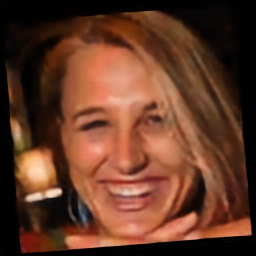

In [25]:
decoded = jax.vmap(model)(wimage)
Image.frombytes('RGB', data=dewhitenen(decoded[0]).tobytes()[3*256*256:6*256*256], size=(256,256))
#dewhitenen(decoded)

In [26]:
decoded[1][0].shape

(2048,)

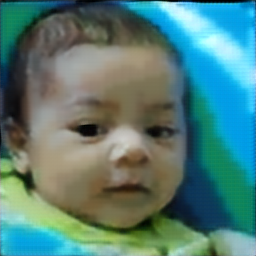

In [29]:
# Recover from a tokenization
dec_token = model.from_encoding(decoded[1][0])
Image.frombytes('RGB', data=dewhitenen(dec_token).tobytes(), size=(256,256))

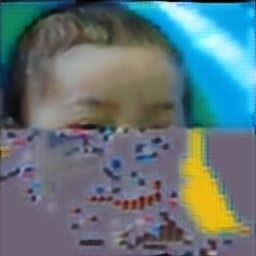

In [60]:
#modify the tokenization
decoded1 = jnp.array(decoded[1][0])
for i in range(1024, 2048):
    decoded1=decoded1.at[i].set(decoded1[i]+2)

dec_token = model.from_encoding(decoded1)
Image.frombytes('RGB', data=dewhitenen(dec_token).tobytes(), size=(256,256))